[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


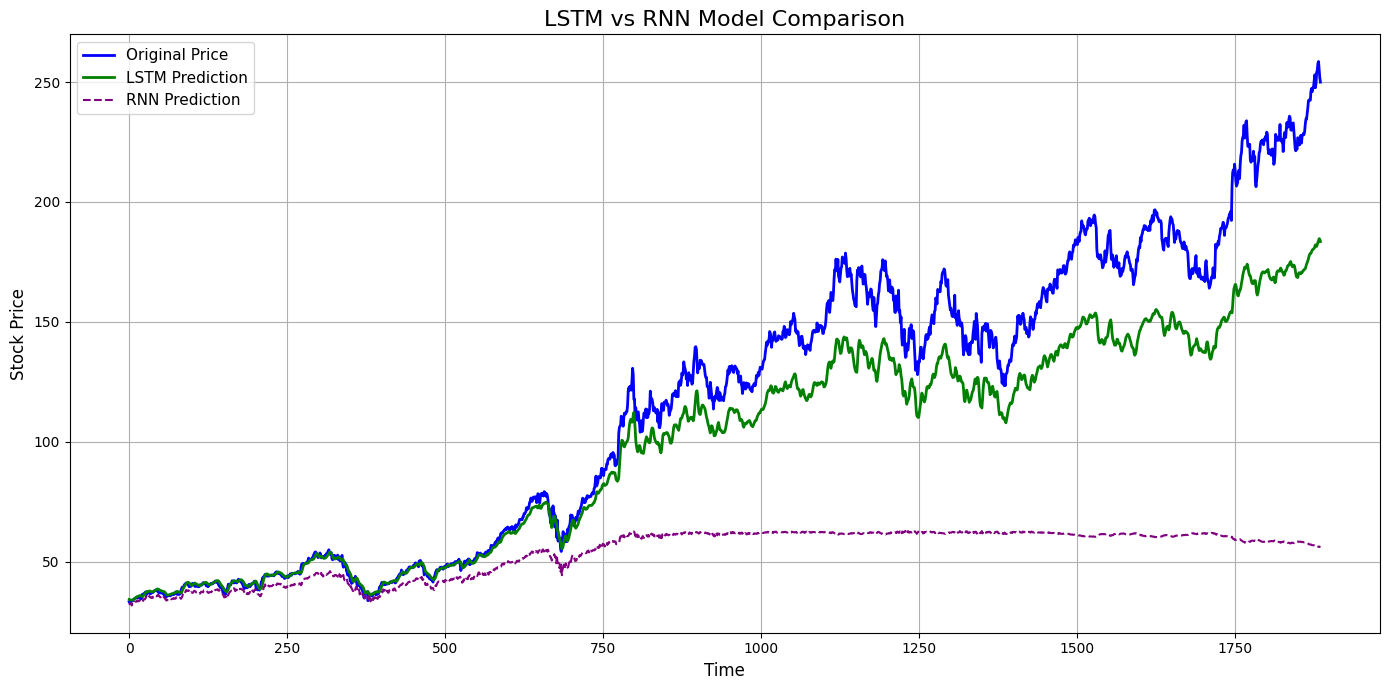

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN

# Fetch stock data
start = '2000-01-01'
end = '2025-01-01'
df = yf.download('AAPL', start=start, end=end)

# Prepare data
df = df.reset_index()
data = df['Close']
data_training = pd.DataFrame(data[0:int(len(data)*0.70)])
data_testing = pd.DataFrame(data[int(len(data)*0.70):])

scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training)

# Create training data
x_train, y_train = [], []
for i in range(100, len(data_training_array)):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Create test data
past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
input_data = scaler.transform(final_df)
x_test, y_test = [], []
for i in range(100, len(input_data)):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])
x_test = np.array(x_test)
y_test_actual = np.array(y_test)

# ==== 1. LSTM Model ====
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.05),
    LSTM(64, activation='tanh'),
    Dropout(0.05),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x_train, y_train, epochs=40, batch_size=64, verbose=0)

lstm_predictions = lstm_model.predict(x_test)
lstm_predictions = lstm_predictions * (1 / scaler.scale_[0])

# Clip LSTM output to remove extreme values (cap to real price range)
price_min, price_max = y_test_scaled.min(), y_test_scaled.max()
lstm_predictions = np.clip(lstm_predictions, price_min, price_max)


# ==== 2. RNN Model ====
rnn_model = Sequential([
    SimpleRNN(32, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.4),
    SimpleRNN(32, activation='tanh'),
    Dropout(0.4),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(x_train, y_train, epochs=8, batch_size=64, verbose=0)

rnn_predictions = rnn_model.predict(x_test)
rnn_predictions = rnn_predictions * (1 / scaler.scale_[0])

# ==== Plotting & Saving ====
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Original Price', color='blue', linewidth=2)
plt.plot(lstm_predictions, label='LSTM Prediction', color='green', linewidth=2)
plt.plot(rnn_predictions, label='RNN Prediction', color='purple', linestyle='dashed', linewidth=1.5)
plt.title('LSTM vs RNN Model Comparison', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True)
plt.tight_layout()

# Save the graph
plt.savefig("static/lstm_vs_rnn_comparison.png")

# Show the graph
plt.show()
